In [2]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import holidays
%matplotlib inline

In [3]:
# ELimina los warnings en la salida de la celda
warnings.simplefilter('ignore')

In [4]:
# Carga de datos de fichero pickle (9010, 31306) Ultimos 30 Años
data_sp = pd.read_pickle("C:/Users/Carap/OneDrive/Escritorio/Proyecto/datasets/data componentes SP500.pkl")

In [5]:
data_sp_copy = data_sp

In [6]:
# Definir Año para filtrar
start_date  =  '2014-10-08'
data_sp['date'] = data_sp_copy.index
data_sp_copy = data_sp_copy.reset_index(drop=True)

In [7]:
# Aqui se filtra
data_sp_copy['date']=pd.to_datetime(data_sp_copy['date'])
datefilter  =  (data_sp_copy['date']  >  start_date )
data_sp_copy  =  data_sp_copy.loc[datefilter] 

In [8]:
# resetear index
data_sp_copy.index = range(data_sp_copy.shape[0])

In [9]:
# guardar date en dataframe 
date = pd.DataFrame(data_sp_copy['date'])
date['date'] =  pd.to_datetime(date['date'])

In [10]:
# extraer nombres de compañias
company=[]
for i in data_sp_copy.columns:
    company.append(i[0]) 

In [11]:
company = list(dict.fromkeys(company))

In [12]:
# elimino date
removeWord = ['date']
company = [word for word in company if word not in removeWord]

In [13]:
# creo una lista con cada companias como dataframe
dataframes = []
for i in company:
    dataframes.append(data_sp_copy[i])

In [14]:
# creo la columna Date con la fecha
for i in enumerate(dataframes):
     i[1]['Date'] = date['date']

In [15]:
## Crear dataframe de tiempo con todos los dias (porque no estaban en el Accurate Quand data)
Timeframe = pd.date_range(start='10/08/2014', end='10/08/2019')
Timeframe = pd.DataFrame(Timeframe)
Timeframe.columns = ['Date']

In [16]:
# Añado los días que faltaban
for i in dataframes:
    i = pd.merge(i, Timeframe, on='Date', how='outer')
    i.sort_values(by = ['Date'], inplace = True)
    i = i.reset_index(drop=True)

In [17]:
# Crear una variable para cada dataframe
# for i, val in enumerate(dataframes): 
#     globals()["dataframe_Sep_%d"%i] = val

In [18]:
# obtengo los holidays para UnitedStates en una lista para los años 2015-16-17-18-19
years = [2014, 2015, 2016, 2017, 2018, 2019]
holidays_date = []
for i in years:
    for j in holidays.UnitedStates(years=i).items():
        holidays_date.append(str(j[0]))

In [19]:
# Se crea una columna con 1 si el dia coincide con la lista creada de dias holidays
for i in enumerate(dataframes):
    i[1].loc[i[1]['Date'].isin(holidays_date), 'Holiday'] = '1'
    i[1].loc[~i[1]['Date'].isin(holidays_date), 'Holiday'] = '0'

In [20]:
# Creo la columna Profitability ((close-open)/open*100) y Day_Week
# Si Week_day es Sabado o domingo o esa fecha es festiva ponme un 0 en el profitability porque no ha habido movimiento
for i in dataframes:
    i['Day_Week'] = i['Date'].dt.weekday_name
    i['Month'] = i['Date'].dt.month
    i['YearMonth'] = i['Date'].dt.to_period('M')
    i['Profitability'] = (i['close']-i['open'])/i['open']*100
    i.loc[(i['Day_Week'] == 'Saturday') | (i['Day_Week'] == 'Sunday') | (i['Holiday'] == 1), 'Profitability'] = 0

In [21]:
# creo la columna company con cada nombre de la compañia
j=0
for i in company:
    dataframes[j]['Company'] = i
    j += 1

In [22]:
# create list to remove some elements from the list of dataframes that do not mathc a condition
delete_dataframes = []

In [23]:
# Eliminate dataframes from list that have a number of NAs in PROFITABILITY is higher than 15%
for j,i in enumerate(dataframes):
    if i['Profitability'].isnull().mean() < 0.15:
        delete_dataframes.append(j)
dataframes = [x for j, x in enumerate(dataframes) if j in delete_dataframes]

In [24]:
# Eliminate columns that have a number of NAs higher than 25%
for i in dataframes:
    null_columns=list(i.columns[i.isnull().any()])

    for j in null_columns:
        if i[j].isnull().mean() < 0.25:
            pass
        else: 
            i = i.drop(columns=[j])

In [25]:
# Create a list of false predictors
false_predictors = ['open', 'high', 'low', 'close', 'bid', 'ask']

In [26]:
# Eliminate the columns that have the false predictors
j = 0
for i in dataframes[j].columns:
    for x in false_predictors:
        if i==x:
            dataframes[j] = dataframes[j].drop(columns=[i])
j += 1

# TODO BIEEEEEEN

# Probar Modelo LSTM -- Notebook: Predicción Fugas

In [28]:
test = dataframes.copy()

In [29]:
prueba = test

In [30]:
prueba[0].isna().sum()

volume                      157
cur_mkt_cap                 158
pe_ratio                    158
tot_debt_to_tot_asset       158
cf_free_cash_flow           158
return_tot_eqy              158
eqy_sh_out                  158
eqy_dvd_yld_ind             158
ebitda                      158
return_on_inv_capital       158
return_on_asset             158
return_on_cap               158
return_com_eqy              158
net_income                  158
short_and_long_term_debt    158
sales_rev_turn              158
gross_profit                158
announcement_dt             158
total_equity                158
close_adj                   158
Date                          0
Holiday                       0
Day_Week                      0
Month                         0
YearMonth                     0
Profitability                17
Company                       0
dtype: int64

In [31]:
prueba[0] = prueba[0][np.isfinite(prueba[0]['Profitability'])]

In [32]:
from keras.models import Sequential
from keras.layers import Dense,  LSTM
from keras import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from time import time

Using TensorFlow backend.


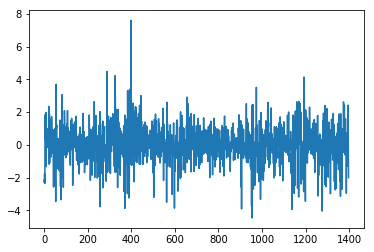

In [33]:
L = len(prueba[0])
Y = prueba[0].iloc[:,-2]
Y= np.array(Y)
Y= Y.reshape(-1,1)
plt.plot(Y)
plt.show(block= False)

In [34]:
X1= Y[0:L-3,:]
X2=Y[1:L-2,:]
X3=Y[2:L-1,:]
Y = Y[3:L,:]
X= np.concatenate([X1,X2,X3],axis=1)
print(f'X shape is {X.shape}')
print(f'Y shape is {Y.shape}')

X shape is (1395, 3)
Y shape is (1395, 1)


In [35]:
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
scaler1 = MinMaxScaler()
scaler1.fit(Y)
Y = scaler1.transform(Y)
X= np.reshape(X, (X.shape[0],1,X.shape[1]))

In [46]:
X_train = X[:int(1412*0.8),:,:]
X_test = X[int(1412*0.8):,:,:]
Y_train = Y[:int(1412*0.8),:]
Y_test = Y[int(1412*0.8):,:]

In [108]:
model = Sequential()
model.add(LSTM(50,activation = 'relu',input_shape = (1,3),recurrent_activation= 'hard_sigmoid'))

In [109]:
model.add(Dense(3))
model.add(Dense(10))
model.add(Dense(60))
model.add(Dense(20))
model.add(Dense(1))

In [76]:
# start=time()
# optimizers = ['rmsprop', 'adam']
# init = ['glorot_uniform', 'normal', 'uniform']
# epochs = np.array([50, 100, 150])
# batches = np.array([5, 10, 20])
# param_grid = dict(optimizer=optimizers, nb_epoch=epochs, batch_size=batches, init=init)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=['r2', 'explained_variance'], refit='r2')

In [105]:
def create_model(optimizer='rmsprop'):
    model = Sequential()
    model.add(LSTM(50,activation = 'relu',input_shape = (1,3),recurrent_activation= 'hard_sigmoid'))
    model.add(Dense(10))
    model.add(Dense(60))
    model.add(Dense(20))
    model.add(Dense(1))
    model.compile(loss= 'mse',optimizer = 'Adam', metrics=[metrics.mae])
    return model

In [110]:
    model.compile(loss= 'mse',optimizer = 'Adam', metrics=[metrics.mae])


In [89]:
# model.fit(X_train,Y_train,epochs=100,verbose=2)

#results = cross_val_score(model, X_train, Y_train, scoring='precision_macro')



Epoch 1/100
 - 1s - loss: 0.0077 - mean_absolute_error: 0.0626
Epoch 2/100
 - 0s - loss: 0.0077 - mean_absolute_error: 0.0628
Epoch 3/100
 - 0s - loss: 0.0078 - mean_absolute_error: 0.0647
Epoch 4/100
 - 0s - loss: 0.0078 - mean_absolute_error: 0.0632
Epoch 5/100
 - 0s - loss: 0.0077 - mean_absolute_error: 0.0629
Epoch 6/100
 - 0s - loss: 0.0078 - mean_absolute_error: 0.0628
Epoch 7/100
 - 0s - loss: 0.0078 - mean_absolute_error: 0.0636
Epoch 8/100
 - 0s - loss: 0.0077 - mean_absolute_error: 0.0630
Epoch 9/100
 - 0s - loss: 0.0077 - mean_absolute_error: 0.0630
Epoch 10/100
 - 0s - loss: 0.0077 - mean_absolute_error: 0.0629
Epoch 11/100
 - 0s - loss: 0.0077 - mean_absolute_error: 0.0628
Epoch 12/100
 - 0s - loss: 0.0077 - mean_absolute_error: 0.0626
Epoch 13/100
 - 0s - loss: 0.0077 - mean_absolute_error: 0.0629
Epoch 14/100
 - 0s - loss: 0.0077 - mean_absolute_error: 0.0627
Epoch 15/100
 - 0s - loss: 0.0078 - mean_absolute_error: 0.0635
Epoch 16/100
 - 0s - loss: 0.0077 - mean_absolute

# MIRARRRRRRRRRRRRRRRRRRRRR

In [111]:
param_grid = {'optimizer':('rmsprop','adam')}
grid = GridSearchCV(model.fit(X_train,Y_train, epochs=100, verbose=2),
                    param_grid=param_grid,
                    return_train_score=True,
                   scoring=['r2', 'explained_variance'],
                    refit='r2')
grid_results = grid.fit(X_train,Y_train)

Epoch 1/100
 - 2s - loss: 0.0326 - mean_absolute_error: 0.1364
Epoch 2/100
 - 0s - loss: 0.0083 - mean_absolute_error: 0.0660
Epoch 3/100
 - 0s - loss: 0.0081 - mean_absolute_error: 0.0638
Epoch 4/100
 - 0s - loss: 0.0080 - mean_absolute_error: 0.0632
Epoch 5/100
 - 0s - loss: 0.0081 - mean_absolute_error: 0.0635
Epoch 6/100
 - 0s - loss: 0.0080 - mean_absolute_error: 0.0631
Epoch 7/100
 - 0s - loss: 0.0080 - mean_absolute_error: 0.0634
Epoch 8/100
 - 0s - loss: 0.0081 - mean_absolute_error: 0.0636
Epoch 9/100
 - 0s - loss: 0.0080 - mean_absolute_error: 0.0633
Epoch 10/100
 - 0s - loss: 0.0081 - mean_absolute_error: 0.0639
Epoch 11/100
 - 0s - loss: 0.0081 - mean_absolute_error: 0.0635
Epoch 12/100
 - 0s - loss: 0.0081 - mean_absolute_error: 0.0644
Epoch 13/100
 - 0s - loss: 0.0080 - mean_absolute_error: 0.0638
Epoch 14/100
 - 0s - loss: 0.0082 - mean_absolute_error: 0.0648
Epoch 15/100
 - 0s - loss: 0.0083 - mean_absolute_error: 0.0650
Epoch 16/100
 - 0s - loss: 0.0082 - mean_absolute

TypeError: estimator should be an estimator implementing 'fit' method, <keras.callbacks.History object at 0x000001FB424E5DD8> was passed

In [78]:
# grid_result = grid.fit(X_train, Y_train)
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# for params, mean_score, scores in grid_result.grid_scores_:
#     print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))
# print("total time:",time()-start)

# MIrar NAns Predicciones

In [ ]:
model.compile(loss= 'mse',optimizer = 'Adam', metrics=[metrics.mae])
model.fit(X_train,Y_train,epochs=100,verbose=2)
Predict = model.predict(X_test)

Epoch 1/100
 - 28s - loss: 0.0332 - mean_absolute_error: 0.1378
Epoch 2/100
 - 1s - loss: 0.0084 - mean_absolute_error: 0.0663
Epoch 3/100
 - 1s - loss: 0.0081 - mean_absolute_error: 0.0635
Epoch 4/100
 - 1s - loss: 0.0081 - mean_absolute_error: 0.0631
Epoch 5/100
 - 1s - loss: 0.0081 - mean_absolute_error: 0.0642
Epoch 6/100
 - 1s - loss: 0.0080 - mean_absolute_error: 0.0637
Epoch 7/100
 - 1s - loss: 0.0080 - mean_absolute_error: 0.0632
Epoch 8/100
 - 1s - loss: 0.0081 - mean_absolute_error: 0.0636
Epoch 9/100


In [381]:
Predict

array([[0.3680157 ],
       [0.3743999 ],
       [0.383246  ],
       [0.3968598 ],
       [0.37192786],
       [0.36606526],
       [0.36718643],
       [0.44506907],
       [0.37795466],
       [0.38786677],
       [0.3657958 ],
       [0.36573952],
       [0.38394374],
       [0.40817   ],
       [0.38095778],
       [0.36623508],
       [0.36773726],
       [0.40386754],
       [0.3655172 ],
       [0.3659522 ],
       [0.39686286],
       [0.40886825],
       [0.36918676],
       [0.3659363 ],
       [0.39301038],
       [0.38138372],
       [0.37738556],
       [0.37741035],
       [0.3759362 ],
       [0.36577538],
       [0.39151138],
       [0.3984644 ],
       [0.3939241 ],
       [0.36552706],
       [0.37061274],
       [0.36931807],
       [0.36608174],
       [0.42697036],
       [0.3692047 ],
       [0.36598626],
       [0.3813379 ],
       [0.3845622 ],
       [0.38410854],
       [0.36581564],
       [0.3907771 ],
       [0.38826144],
       [0.3846041 ],
       [0.365

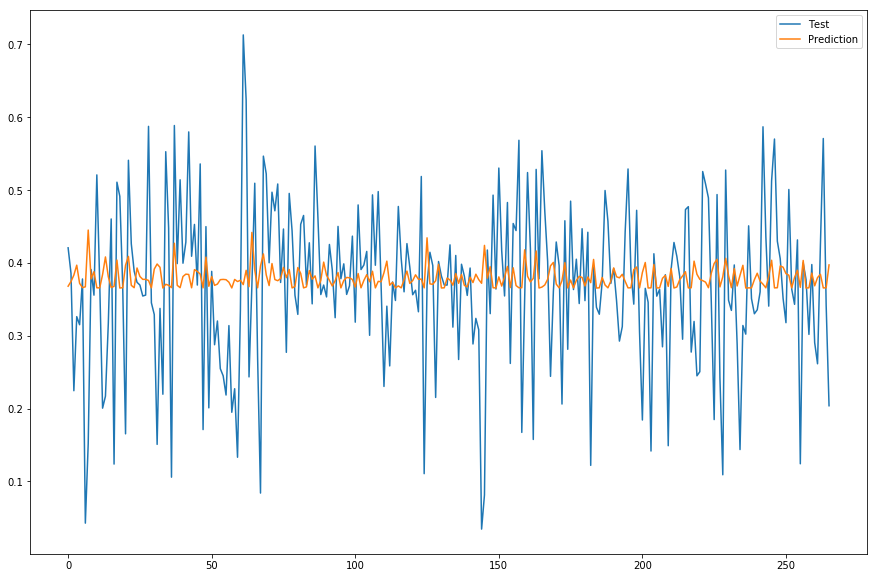

In [382]:
plt.figure(figsize=(15,10))
plt.plot(Y_test,label = 'Test')
plt.plot(Predict, label = 'Prediction')
plt.legend(loc='best')
plt.show()

In [ ]:
# start=time()
# model = KerasClassifier(build_fn=create_model)
# optimizers = ['rmsprop', 'adam']
# init = ['glorot_uniform', 'normal', 'uniform']
# epochs = np.array([50, 100, 150])
# batches = np.array([5, 10, 20])
# param_grid = dict(optimizer=optimizers, nb_epoch=epochs, batch_size=batches, init=init)
# grid = GridSearchCV(estimator=model, param_grid=param_grid)
# grid_result = grid.fit(X_train, Y_train)
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# for params, mean_score, scores in grid_result.grid_scores_:
#     print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))
# print("total time:",time()-start)